# Решение матричной игры с помощью симплекс-метода

In [24]:
import numpy as np
import os
import sys


# Проверка на наличие седловой точки.
Если седловая точка существует, то возвращаются ее координаты. В таком случае, решение игры выписывается в чистых стратегиях.

In [25]:
def saddle_point(a):
    m = len(a); n = len(a[0])
    min_a = np.zeros(m)
    max_a = np.zeros(n)
    for i in range(m):
        min_a[i] = np.min(a[i])
      
    for j in range(n):
        max_a[j] = np.max(a[:,j])
        
    maxmin = np.max(min_a)
    minmax = np.min(max_a)
    if maxmin == minmax:
        index_max = np.where(min_a == maxmin)[0][0]
        index_min = np.where(max_a == minmax)[0][0]
        return a[index_max], a[:,index_min] 
    return -1, -1

# Удаление доминируемых строк и столбцов
Говорят, что $i$-я стратегия 1-го игрока доминирует его $k$-ю стратегию, если $a_{ij}$ ≥ $a_{kj}$ для всех $j \in N$ и хотя бы для одного $j$ $a_{ij} > a_{kj}$. В этом случае говорят также, что $i$-я стратегия (или строка) – доминирующая, $k$-я – доминируемая. 

Говорят, что $j$-я стратегия 2-го игрока доминирует его $l$-ю стратегию, если для всех $j \in M$ $a_{ij} ≤ a_{il}$ и хотя бы для одного $i$ $a_{ij} < a_{il}$. В этом случае $j$-ю стратегию (столбец) называют доминирующей, $l$-ю – доминируемой. 

In [26]:
def dominant_strategies(a):
    m = len(a); n = len(a[0])
    rows = np.zeros((0))
    cols = np.zeros((0))
    delete = 0
    for i in range(m):
        if i >= m:
            continue
        for j in range(m):
            if j >= m or i >= m:
                continue
            if i != j:
                if np.prod(a[i] >= a[j]) == 1:
                    a = np.delete(a, (j), axis=0)
                    rows = np.append(rows,j + delete)
                    delete += 1
                    m = len(a)
                    j -= 1
                    i -= 1
                    
      
    delete = 0          
    for i in range(n):
        if i >= n:
            continue
        for j in range(n):
            if j >= n or i >= n:
                continue
            if i != j:
                if np.prod(a[:,i] <= a[:,j]) == 1:
                    a = np.delete(a, (j), axis=1)
                    cols = np.append(cols,j+delete)
                    delete += 1
                    n = len(a[0])
                    j -= 1
                    i -= 1
    return a, rows, cols

# Создание симплекс-таблицы

In [27]:
def create_s0(a):
    if np.min(a) < 0:
        a += abs(np.min(a))
    m = len(a); n = len(a[0])
    s0 = np.zeros((n+1,m+2))
    
    for j in range(1,m+1):
        s0[n][j] = 1
    for i in range(n):
        s0[i][0] = -1
        for j in range(1,m+1):
            s0[i][j] = -a[j-1][i]
            
    return s0  

# Реализация алгоритма симплекс-метода

In [28]:

def simplex(s0,indices):
    m = len(s0); n = len(s0[0])
    min_el = np.min(s0[:-1,0])
    if min_el >= 0:
        return 1
    
    leading_row = (np.where(s0[:-1,0] == min_el))[0][0]
    
    min_ = leading_col = 1000
    for i in range(1,n-1):
        if s0[leading_row][i] < 0:
            temp = abs(s0[m-1][i] / s0[leading_row][i])
            if temp < min_:
                min_ = temp
                leading_col = i
    leading_el = s0[leading_row][leading_col]            
    index_col = indices[leading_col-1]
    index_row = indices[leading_row + n - 2]
    indices[leading_col - 1] = index_row
    indices[leading_row + n - 2] = index_col
  
    for j in range(n-1):
        s0[leading_row][j] /= leading_el
    s0[leading_row][leading_col] = 1 / leading_el
    
    for i in range(m):
        s0[i][n-1] = - s0[i][leading_col]
    for i in range(m):
        if i == leading_row:
            continue
        for j in range(n-1):
            if j == leading_col:
                s0[i][j] = s0[leading_row][j] * s0[i][n-1]
            else:
                s0[i][j] += s0[leading_row][j] * s0[i][n-1]           
    return 0
 

# Основная функция
Строит симплекс-таблицы. Возвращает оптимальные стратегии игроков.

In [29]:
   
def nash_equilibrium(a):
    m0= len(a); n0 = len(a[0])
    strategy1, strategy2 = saddle_point(a)
    if isinstance(strategy1, int) == 0:
        print("\nEquillibrium situation.")
        print("Optimal strategy for the first player: ", strategy1)
        print("Optimal strategy for the second player: ", strategy2)
        return 0
    a, rows, cols = dominant_strategies(a)
    s0 = create_s0(a)
    m = len(a); n = len(a[0])
    indices = [i+1 for i in range(m+n)]
    
    sign = 0
    while sign == 0:
        sign = simplex(s0, indices)
        
    x = np.zeros(m); y = np.zeros(n)    
    for i in range(m+n):
        if i < m and indices[i] > m:
            y[indices[i]-m-1] = s0[n][i+1]
        elif i >= m and indices[i] <= n:
            x[indices[i]-1] = s0[i-m][0]
            
    v = 1/np.sum(x)      
    p = np.zeros(m0); q = np.zeros(n0)
    j = 0
    for i in range(m0):
        if i in rows:
            continue
        if j >= m:
            break
        p[i] = x[j] * v
        j += 1
    j = 0   
    for i in range(n0):
        if i in cols:
            continue
        if j >= n:
            break
        q[i] = y[j] * v
        j += 1
    
    print("\nGame price v = ",v)
    print("\nOptimal strategy for the first player:\n ", p)
    print("\nOptimal strategy for the second player:\n ", q)
    return p,q

# Считывание матриц с файла

In [30]:

def read_matrix(file):
    return np.loadtxt(file, dtype='f', delimiter=' ')

# Main

In [31]:
if __name__ == "__main__":
    if len(sys.argv) > 3:
        a = read_matrix(sys.argv[1])
    else:        
        #Считываем платежную матрицу
        path = os.path.join('.','files','matrix_a.txt')   
        a = read_matrix(path)
print("Input matrix:\n",a)


Input matrix:
 [[ 4.  0.  6.  2.  2.  1.]
 [ 3.  8.  4. 10.  4.  4.]
 [ 1.  2.  6.  5.  0.  0.]
 [ 6.  6.  4.  4. 10.  3.]
 [10.  4.  6.  4.  0.  9.]
 [10.  7.  0.  7.  9.  8.]]


In [32]:
p,q = nash_equilibrium(a)


Game price v =  4.870967741935486

Optimal strategy for the first player:
  [0.         0.12903226 0.09677419 0.43548387 0.33870968 0.        ]

Optimal strategy for the second player:
  [0.         0.         0.69086022 0.14516129 0.14784946 0.01612903]


# Визуализация спектров оптимальных стратегий

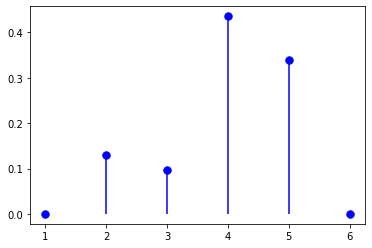

In [33]:
import matplotlib.pyplot as plt

i = 0
x = [i+1 for i in range(len(p))]
i = 0
y1 = [0 for i in range(len(p))]

plt.vlines(x, ymin=y1, ymax=p, color='blue')
plt.scatter(x, p, s=55, color='blue')
plt.show()